<a href="https://colab.research.google.com/github/sthalles/SimCLR/blob/master/feature_eval/linear_feature_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
folder_name = '/home/yoyo/Desktop/SimCLR/runs/resnet-18_100-epochs'

In [33]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import importlib.util

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [35]:
checkpoints_folder = os.path.join(folder_name, 'checkpoints')
config = yaml.load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

{'batch_size': 512,
 'epochs': 80,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'None',
 'log_every_n_steps': 50,
 'weight_decay': '10e-6',
 'fp16_precision': False,
 'model': {'out_dim': 256, 'base_model': 'resnet18'},
 'dataset': {'s': 1,
  'input_shape': '(96,96,3)',
  'num_workers': 0,
  'valid_size': 0.05},
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True}}

In [36]:
checkpoints_folder

'/home/yoyo/Desktop/SimCLR/runs/resnet-18_100-epochs/checkpoints'

In [37]:
def _load_stl10(prefix="train"):
    X_train = np.fromfile('../data/stl10_binary/' + prefix + '_X.bin', dtype=np.uint8)
    y_train = np.fromfile('../data/stl10_binary/' + prefix + '_y.bin', dtype=np.uint8)

    X_train = np.reshape(X_train, (-1, 3, 96, 96)) # CWH
    X_train = np.transpose(X_train, (0, 1, 3, 2)) # CHW

    print("{} images".format(prefix))
    print(X_train.shape)
    print(y_train.shape)
    return X_train, y_train - 1

In [38]:
# load STL-10 train data
X_train, y_train = _load_stl10("train")

train images
(5000, 3, 96, 96)
(5000,)


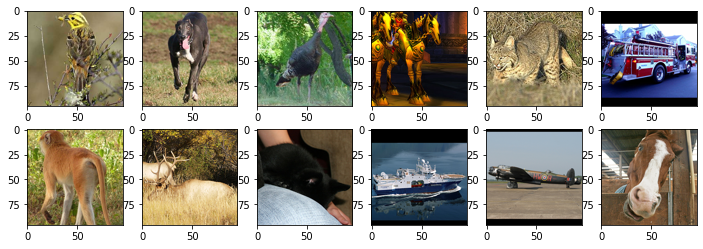

In [39]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
  ax.imshow(X_train[i].transpose(1,2,0))
plt.show()

In [40]:
# load STL-10 test data
X_test, y_test = _load_stl10("test")

test images
(8000, 3, 96, 96)
(8000,)


## Test protocol #1 PCA features

In [41]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train.reshape((X_train.shape[0],-1)))

pca = PCA(n_components=config['model']['out_dim'])

X_train_pca = pca.fit_transform(scaler.transform(X_train.reshape(X_train.shape[0], -1)))
X_test_pca = pca.transform(scaler.transform(X_test.reshape(X_test.shape[0], -1)))

print("PCA features")
print(X_train_pca.shape)
print(X_test_pca.shape)

PCA features
(5000, 256)
(8000, 256)


In [42]:
def linear_model_eval(X_train, y_train, X_test, y_test):
    
    clf = LogisticRegression(random_state=0, max_iter=1200, solver='lbfgs', C=1.0)
    clf.fit(X_train, y_train)
    print("Logistic Regression feature eval")
    print("Train score:", clf.score(X_train, y_train))
    print("Test score:", clf.score(X_test, y_test))
    
    print("-------------------------------")
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train)
    print("KNN feature eval")
    print("Train score:", neigh.score(X_train, y_train))
    print("Test score:", neigh.score(X_test, y_test))

In [43]:
linear_model_eval(X_train_pca, y_train, X_test_pca, y_test)

## clean up resources
del X_train_pca
del X_test_pca

Logistic Regression feature eval
Train score: 0.495
Test score: 0.351
-------------------------------
KNN feature eval
Train score: 0.4046
Test score: 0.3015


## Protocol #2 Logisitc Regression

In [44]:
# Load the neural net module
spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, '../../../models/resnet_simclr.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

In [45]:
model = resnet_module.ResNetSimCLR(**config['model'])
model.eval()

state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

Feature extractor: resnet18


In [46]:
def next_batch(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        y_batch = torch.tensor(y[i: i+batch_size])
        yield X_batch.to(device), y_batch.to(device)

In [47]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

Train features
(5000, 512)


In [48]:
X_test_feature = []

for batch_x, batch_y in next_batch(X_test, y_test, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_test_feature.extend(features.cpu().detach().numpy())
    
X_test_feature = np.array(X_test_feature)

print("Test features")
print(X_test_feature.shape)

Test features
(8000, 512)


In [49]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_feature)

linear_model_eval(scaler.transform(X_train_feature), y_train, scaler.transform(X_test_feature), y_test)

del X_train_feature
del X_test_feature

Logistic Regression feature eval
Train score: 0.9498
Test score: 0.73625
-------------------------------
KNN feature eval
Train score: 0.7632
Test score: 0.69425
